In [ ]:
#Necessary imports
!pip install bitsandbytes datasets -U
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, TrainingArguments, Trainer
import torch
from datasets import load_dataset, Dataset
from google.colab import drive
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
import bitsandbytes
import os
from transformers import AutoModelForCausalLM
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model

torch.cuda.empty_cache()
import gc
gc.collect()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 32.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

120

In [ ]:
#environment preparation
drive.mount('/content/drive/')
path = '/content/drive/Shareddrives/DeepLearning/UPF_Deep_Learning_2025/Project/Codi'

#!pip install -q transformers datasets accelerate peft bitsandbytes

#!pip install -U bitsandbytes

model_name = "openai-community/gpt2"

# Define the BitsAndBytesConfig for 4-bit quantization
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16, # Use bfloat16 for computation
)

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
# Set the padding token to be the EOS token
tokenizer.pad_token = tokenizer.eos_token
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto",
    trust_remote_code=True
)


Mounted at /content/drive/


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
# data preparation

dataset = load_dataset("suayptalha/Poetry-Foundation-Poems")

# Assuming dataset initially only has a 'train' split,
# split the 'train' split into training and testing sets
train_test_split_dataset = dataset['train'].train_test_split(test_size=0.2) # Allocate 20% for testing

def tokenize(example):
    tokenized_output = tokenizer(example["Poem"], padding="max_length", truncation=True, max_length=512)
    # Add labels for causal language modeling training
    tokenized_output["labels"] = tokenized_output["input_ids"]
    return tokenized_output

# Apply tokenization to the new splits
tokenized_dataset = train_test_split_dataset.map(tokenize, batched=True, remove_columns=[ "Title", "Poet", "Tags"])

os.environ["WANDB_DISABLED"] = "true"

# Prepare model for LoRA training
model = prepare_model_for_kbit_training(model)
config = LoraConfig(r=8, lora_alpha=32, target_modules=["c_attn"], lora_dropout=0.05, bias="none", task_type="CAUSAL_LM")
model = get_peft_model(model, config)
model.print_trainable_parameters()

README.md:   0%|          | 0.00/2.69k [00:00<?, ?B/s]

PoetryFoundationData.csv:   0%|          | 0.00/23.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/13854 [00:00<?, ? examples/s]

Map:   0%|          | 0/11083 [00:00<?, ? examples/s]

Map:   0%|          | 0/2771 [00:00<?, ? examples/s]

trainable params: 294,912 || all params: 124,734,720 || trainable%: 0.2364


/usr/local/lib/python3.11/dist-packages/peft/tuners/lora/layer.py:1768: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


In [ ]:
#Testing the model before training - seguir una frase
prompt = "The sea is blue, the sky is red"

# Tokenize input
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

# Generate text
output = model.generate(
    **inputs,
    max_new_tokens=250,
    temperature=0.7,
    top_p=0.95,
    do_sample=True,
    repetition_penalty=1.1,
    eos_token_id=tokenizer.eos_token_id
)

# Decode and print
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print(generated_text)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The sea is blue, the sky is red. The sun shines on you like a bright light."
"I'm sorry to say I'll miss that day," said Zu-Li who had been sitting in silence for so long with her lips pursed and expression fixed onto hers as if she were talking about something else yet again. She was smiling happily when Yang heard him tell it all: "We're going home now..." That comment made many of them cry out through their tears; one even came from someone they knew well! There must have been some other reason behind his actions at this point too... It wasn't just what he wanted or expected but also how hard Yuzhao really struggled because without any help whatsoever between those two people there would be no way Nanyang could come back alive!! So much love flowed into each others eyes while still holding such an important connection… Even though everyone felt slightly lost after hearing these words which only spoke volumes (even during times where not knowing anything), both men understood clearly

In [ ]:
#Testing the model before training - seguir una instrucció
prompt = "Write a poem about the sea and the sky"

# Tokenize input
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

# Generate text
output = model.generate(
    **inputs,
    max_new_tokens=250,
    temperature=0.7,
    top_p=0.95,
    do_sample=True,
    repetition_penalty=1.1,
    eos_token_id=tokenizer.eos_token_id
)

# Decode and print
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print(generated_text)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Write a poem about the sea and the sky.
I found it so wonderful that I decided to write an essay on my own, which is what prompted me to do this project: It started out as just creating poetry for friends who have no idea how much of their life they live in but are looking forward to doing something amazing with nature when all we've been thinking was 'what if?'


In [ ]:
training_args = TrainingArguments(
    output_dir=os.path.join(path, "deep_optimized"),
    per_device_train_batch_size=2,  # Small due to Colab memory limits
    gradient_accumulation_steps=8,  # Simulates effective batch size = 16
    num_train_epochs=3,  # Higher for better generalization
    learning_rate=5e-5,  # Safer than 1e-4; avoids divergence
    weight_decay=0.01,  # Encourages sparsity, reduces overfitting
    lr_scheduler_type="cosine",  # Cosine decay works great for transformers
    fp16=True,  # Great for Colab GPUs
    logging_steps=25,
    save_strategy="epoch",
    save_total_limit=2,
    greater_is_better=False,
    report_to="none"
)

# Trainer
trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['test']
)


trainer.train()

<ipython-input-6-d1e5acef0f2f>:18: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
25,6.987200
50,5.904100
75,4.701200
100,4.109300
125,3.554600
150,3.236300
175,2.906600
200,2.873300
225,2.860600
250,2.785000


TrainOutput(global_step=2079, training_loss=2.6038737446141393, metrics={'train_runtime': 1686.7409, 'train_samples_per_second': 19.712, 'train_steps_per_second': 1.233, 'total_flos': 8717821357326336.0, 'train_loss': 2.6038737446141393, 'epoch': 3.0})

In [ ]:
prompt = "The sea is blue, the sky is red"

# Tokenize input
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

# Generate text
output = model.generate(
    **inputs,
    max_new_tokens=250,
    temperature=0.7,
    top_p=0.95,
    do_sample=True,
    repetition_penalty=1.1,
    eos_token_id=tokenizer.eos_token_id
)

# Decode and print
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print(generated_text)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The sea is blue, the sky is red, and there are no clouds. You can't see any of these things until you've done this task (you'll be sure to keep an eye out for them). It's a wonderful feeling when one finds it on their own feet or in your hand like some sort ooze! But I think that would require someone who knows how to read before diving into deep thought—a very helpful guy with whom I have had trouble getting my bearings back up at all levels...who has been through so many trials....and yet was able [to dive] without losing his balance..the same way he did during those last days after leaving home because we couldn"t get him right by touching our toes.....therefore they might want us over here too."



In [ ]:
eval_results = trainer.evaluate()
print(eval_results)

{'eval_loss': 2.2335407733917236, 'eval_runtime': 58.4785, 'eval_samples_per_second': 47.385, 'eval_steps_per_second': 5.934, 'epoch': 3.0}


In [ ]:
#Testing the model before training - seguir una frase
prompt = "The sea is blue, the sky is red"

# Tokenize input
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

# Generate text
output = model.generate(
    **inputs,
    max_new_tokens=250,
    temperature=0.7,
    top_p=0.95,
    do_sample=True,
    repetition_penalty=1.1,
    eos_token_id=tokenizer.eos_token_id
)

# Decode and print
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print(generated_text)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


The sea is blue, the sky is red, and there are no ghosts in it. It's a beautiful thing to see: only water flows out of its mouth with clear sunlight."

But for all that fame, he said, "it was not always about sex—people were afraid of losing their virginity sometimes; but even then they didn't want to be alone anymore. I think we should have had more control over what people wanted or refused."


In [ ]:
#Testing the model before training - seguir una instrucció
prompt = "Write a poem about the sea and the sky"

# Tokenize input
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

# Generate text
output = model.generate(
    **inputs,
    max_new_tokens=250,
    temperature=0.7,
    top_p=0.95,
    do_sample=True,
    repetition_penalty=1.1,
    eos_token_id=tokenizer.eos_token_id
)

# Decode and print
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print(generated_text)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Write a poem about the sea and the sky.
But there is no heaven in sight, nor can I tell you where it comes from.
In my mind, which has been filled with suffering, and what lies beyond;


In [ ]:

# Merge LoRA into base model
merged_model = model.merge_and_unload()

# Now merged_model is a standard AutoModelForCausalLM
# You can save it as a normal model
merged_model.save_pretrained(os.path.join(path, "copia_funciona_gpt2"))
tokenizer.save_pretrained(os.path.join(path, "copia_funciona_gpt2"))



('/content/drive/Shareddrives/DeepLearning/UPF_Deep_Learning_2025/Project/Codi/copia_funciona_gpt2/tokenizer_config.json',
 '/content/drive/Shareddrives/DeepLearning/UPF_Deep_Learning_2025/Project/Codi/copia_funciona_gpt2/special_tokens_map.json',
 '/content/drive/Shareddrives/DeepLearning/UPF_Deep_Learning_2025/Project/Codi/copia_funciona_gpt2/vocab.json',
 '/content/drive/Shareddrives/DeepLearning/UPF_Deep_Learning_2025/Project/Codi/copia_funciona_gpt2/merges.txt',
 '/content/drive/Shareddrives/DeepLearning/UPF_Deep_Learning_2025/Project/Codi/copia_funciona_gpt2/added_tokens.json',
 '/content/drive/Shareddrives/DeepLearning/UPF_Deep_Learning_2025/Project/Codi/copia_funciona_gpt2/tokenizer.json')

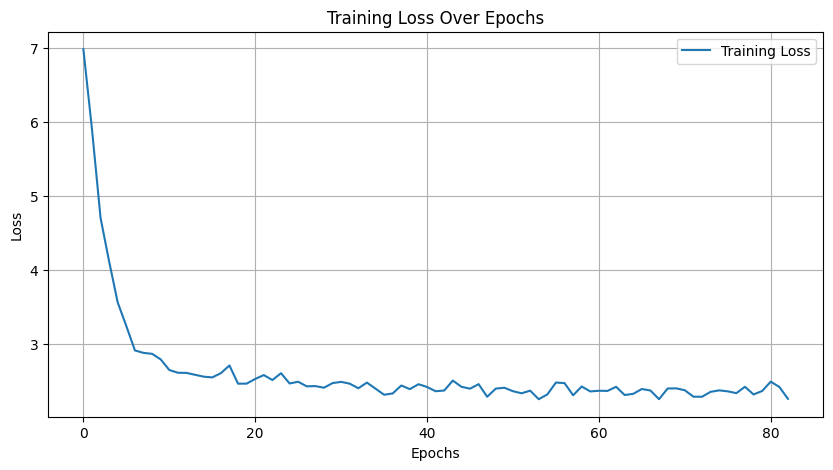

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have a ⁠ trainer ⁠ object after training
history = trainer.state.log_history

# Extract training and validation losses
train_loss = [log['loss'] for log in history if 'loss' in log]

# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()